In [9]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import mplhep as hep
plt.style.use(hep.style.CMS)

In [10]:
loss_list = torch.load('/diffusionvol/experiments/train_generation/2022-11-06-19-04-54/loss_list_123.pt')

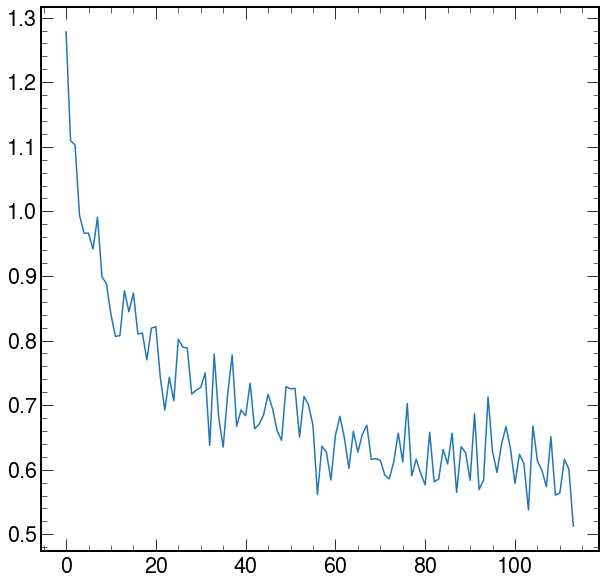

In [11]:
plt.plot(loss_list[10:])

In [12]:
samples = torch.load('/diffusionvol/experiments/test_generation/pvd_gluons/syn/samples.pth')
ref = torch.load('/diffusionvol/experiments/test_generation/pvd_gluons/syn/ref.pth')
samples = samples.numpy()
ref = ref.numpy()

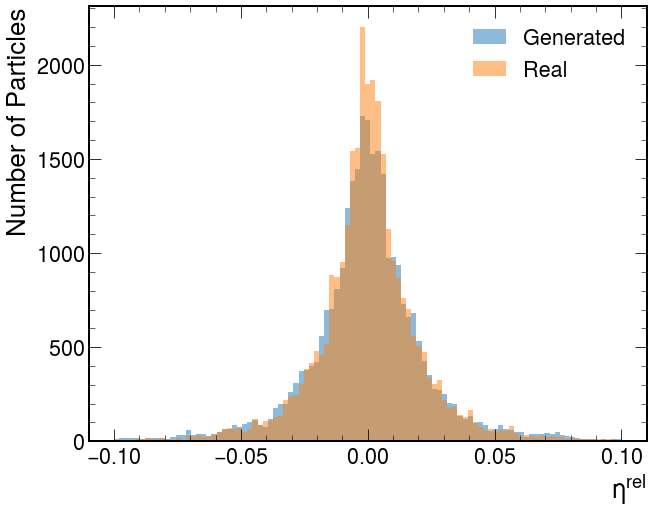

In [23]:
plt.figure(figsize=(10,8))
plt.hist(samples[..., 0].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 0].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$\eta^{rel}$")
plt.ylabel('Number of Particles')
plt.savefig('eta.png')
plt.show()

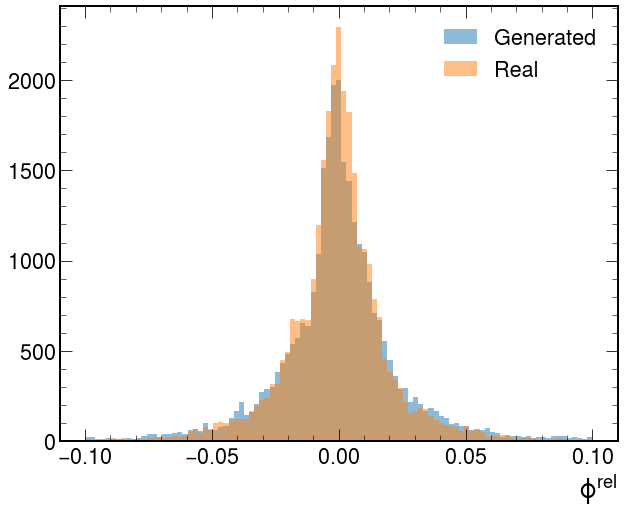

In [24]:
plt.style.use(hep.style.CMS)
plt.figure(figsize=(10,8))
plt.hist(samples[..., 1].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 1].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$\phi^{rel}$")
plt.savefig('phi.png')
plt.show()

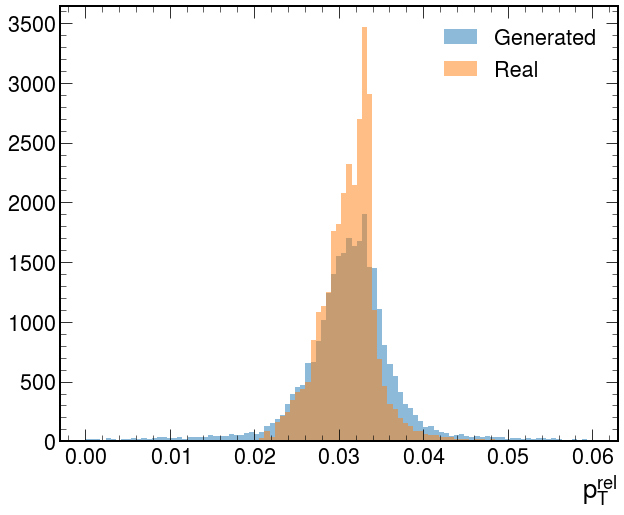

In [25]:
plt.style.use(hep.style.CMS)
plt.figure(figsize=(10,8))
plt.hist(samples[..., 2].flatten(), bins=np.linspace(-0.0, 0.06, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 2].flatten(), bins=np.linspace(-0.0, 0.06, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$p_T^{rel}$")
plt.savefig('pt.png')
plt.show()

In [39]:
from jetnet import evaluation

In [59]:
samples_pt_pos = samples
samples_pt_pos[..., -1] = samples_pt_pos[..., -1].clip(min=0)

In [60]:
cov, mmd = evaluation.cov_mmd(samples_pt_pos, ref)

Calculating cov and mmd over 10 batches: 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


In [63]:
print(f'COV: {cov}')
print(f'MMD: {mmd}')

COV: 0.48900000000000005
MMD: 0.06887106085786879


In [72]:
w1efpm, w1efpstd = evaluation.w1efp(
    samples,
    ref,
    use_particle_masses=False,
    average_over_efps=True,
    return_std=True
)
print(w1efpm, w1efpstd)

0.06702151063539728 0.014686998340557705


In [74]:
fpd = evaluation.fpnd(samples, jet_type='g')

OSError: /opt/conda/lib/python3.9/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs